# Logistic Regression as a Single Neuron Model

## Imports

In [1]:
import numpy as np
import h5py
import requests
import os
import matplotlib.pyplot as plt

## Helper Functions (Just run this cell - no need to go through the code in helper functions)

In [2]:
def download_file(url, local_filename):
    """
    Downloads a file from a URL and saves it locally.
    """
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_filename, 'wb') as f:
                f.write(response.content)
            print(f"File downloaded: {local_filename}")
        else:
            raise Exception(f"Failed to download file from {url}. Status code: {response.status_code}")
    else:
        print(f"File already exists: {local_filename}")

def load_dataset():
    # URLs of the .h5 files
    train_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/train_catvnoncat.h5'
    test_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/test_catvnoncat.h5'

    # Local file paths
    train_file = 'train_catvnoncat.h5'
    test_file = 'test_catvnoncat.h5'

    # Download the files if not already present
    download_file(train_url, train_file)
    download_file(test_url, test_file)

    # Open the files using h5py
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Train set labels

    test_dataset = h5py.File(test_file, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # Test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # Test set labels

    classes = np.array(test_dataset["list_classes"][:])  # List of classes

    # Reshape labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Importing Dataset

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

File downloaded: train_catvnoncat.h5
File downloaded: test_catvnoncat.h5


## Data Visualization

label:  [1]


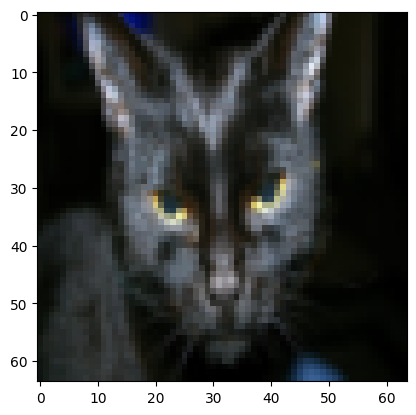

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print("label: ", train_set_y[:, index])

### **Exercise 1:** Take a look at five different images in train/test set. Try to see both cat and non-cat samples.

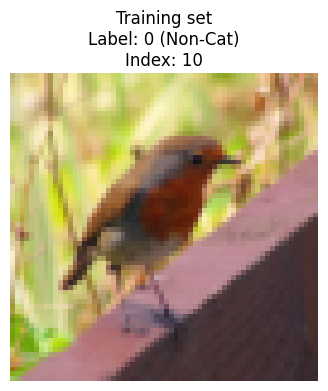

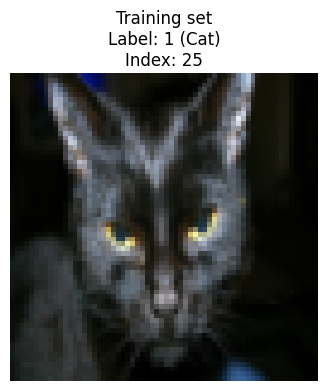

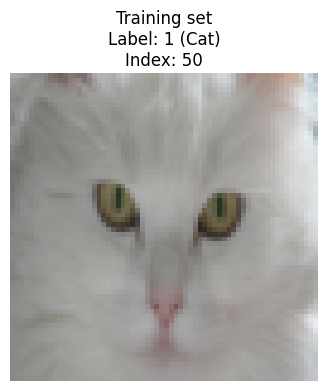

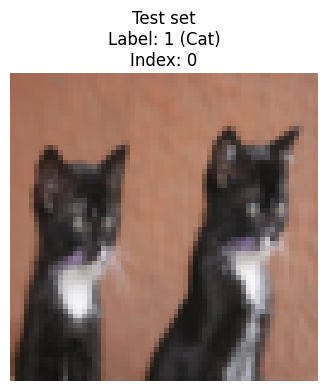

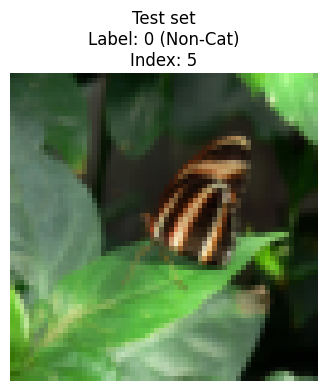

In [5]:
def show_image(image, label, index, set_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{set_name} set\nLabel: {label[0]} ({'Cat' if label[0] == 1 else 'Non-Cat'})\nIndex: {index}")
    plt.axis('off')
    plt.show()

# Training set images
for i in [10, 25, 50]:
    show_image(train_set_x_orig[i], train_set_y[:, i], i, "Training")

# Test set images
for i in [0, 5]:
    show_image(test_set_x_orig[i], test_set_y[:, i], i, "Test")


### **Exercise 2:** What percentage of the pictures in `train set` contain cats?

In [6]:
num_cat_pictures = np.sum(train_set_y[0] == 1)

# Calculate the total number of pictures in the training set
total_pictures = train_set_y.shape[1]

# Calculate the percentage
percentage_cats = (num_cat_pictures / total_pictures) * 100

print(f"Number of cat pictures: {num_cat_pictures}")
print(f"Total number of pictures: {total_pictures}")
print(f"Percentage of pictures containing cats: {percentage_cats:.2f}%")


Number of cat pictures: 72
Total number of pictures: 209
Percentage of pictures containing cats: 34.45%


## Data Pre-processing

### Brief Theory: Numerical Representation of Images

![preprocessing](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imvectorkiank.png)

### Simple Numerical Example

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imtovec_example.webp)

#### Step 1: Numerical representation of each channel

In [17]:
red_channel = np.array([[255, 123, 135], [44, 12, 15], [56, 87, 90]]) # 2d array: Matrix
green_channel = np.array([[255, 133, 175], [24, 123, 169], [98, 66, 77]])
blue_channel = np.array([[66, 54, 88], [55, 98, 54], [87, 142, 89]])

print("Red Channel")
print(red_channel.shape)
print(red_channel)

print("Green Channel")
print(green_channel.shape)
print(green_channel)

print("Bue Channel")
print(blue_channel.shape)
print(blue_channel)



Red Channel
(3, 3)
[[255 123 135]
 [ 44  12  15]
 [ 56  87  90]]
Green Channel
(3, 3)
[[255 133 175]
 [ 24 123 169]
 [ 98  66  77]]
Bue Channel
(3, 3)
[[ 66  54  88]
 [ 55  98  54]
 [ 87 142  89]]


#### Step 2: Putting the channels together in the form of a tensor

In [18]:
print("channel, height, width")
airplane_image = np.array([red_channel, green_channel, blue_channel])  # 3d array: Tensor
print(airplane_image.shape)
print(airplane_image)

channel, height, width
(3, 3, 3)
[[[255 123 135]
  [ 44  12  15]
  [ 56  87  90]]

 [[255 133 175]
  [ 24 123 169]
  [ 98  66  77]]

 [[ 66  54  88]
  [ 55  98  54]
  [ 87 142  89]]]


#### Step 3: Flatten the tensor into a vector

In [19]:
airplane_flatten = airplane_image.flatten()   # 1d array: Vector
print(airplane_flatten.shape)
print(airplane_flatten)

(27,)
[255 123 135  44  12  15  56  87  90 255 133 175  24 123 169  98  66  77
  66  54  88  55  98  54  87 142  89]


### **Exercise 3:** Take one sample form train set again and check the shape of it. Try to interpret the numbers in the `shape`.

**Notes:**
- The images are 64x64 `pixels`.
- There are 3 RGB `channels`.

Shape of the sample image: (64, 64, 3)
Dimensions interpretation:
- Height: 64 pixels
- Width: 64 pixels
- Channels: 3


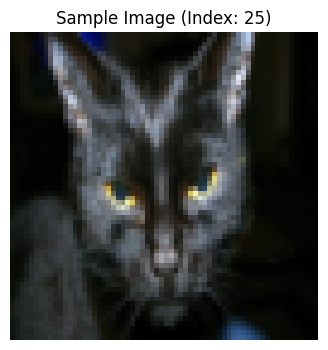

In [7]:
sample_index = 25
sample_image = train_set_x_orig[sample_index]

print(f"Shape of the sample image: {sample_image.shape}")
print(f"Dimensions interpretation:")
print(f"- Height: {sample_image.shape[0]} pixels")
print(f"- Width: {sample_image.shape[1]} pixels")
print(f"- Channels: {sample_image.shape[2]}")

# Visualize the image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Sample Image (Index: {sample_index})")
plt.axis('off')
plt.show()


### Exercise 4: Fallaten the this sample image? what is the size of the flattened image? why this number?

In [20]:
flattened_image = sample_image.flatten()
flattened_size = flattened_image.shape[0]

print(f"Size of the flattened image: {flattened_size}")


Size of the flattened image: 12288


### Data Preprocessing: Flattening the entrie Train and Test Datasets

In [10]:
train_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
print(train_flat.shape)

test_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
print(test_flat.shape)

train_label = train_set_y[0]
print(train_label.shape)

test_label = test_set_y[0]
print(test_label.shape)



(209, 12288)
(50, 12288)
(209,)
(50,)


**Important Notes:**
- We have 209 samples in the train set, and
- 50 samples in the test set.
- each sample has 64x64x3=12288 `features`. So each pixel can be considered as one feature.
- remember that we had `4` features in `IRIS` dataset and now we have more than `10,000` features.

## Implementing Logistic Regression

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/LogReg_kiank.png)

### **Exercise 5:** Train a `LogisticRegression` classifier to run a binary classification on the flattened cat pictures.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(train_flat, train_label)

# Make predictions on train and test sets
train_predictions = logistic_model.predict(train_flat)
test_predictions = logistic_model.predict(test_flat)

# Calculate accuracies
train_accuracy = accuracy_score(train_label, train_predictions)
test_accuracy = accuracy_score(test_label, test_predictions)

print("Logistic Regression Results:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(test_label, test_predictions, target_names=['Non-Cat', 'Cat']))


Logistic Regression Results:
Train Accuracy: 1.0000
Test Accuracy: 0.6600

Classification Report (Test Set):
              precision    recall  f1-score   support

     Non-Cat       0.50      0.65      0.56        17
         Cat       0.79      0.67      0.72        33

    accuracy                           0.66        50
   macro avg       0.64      0.66      0.64        50
weighted avg       0.69      0.66      0.67        50



### **Exercise 6:** Evaluate your model manually

1. Choose a random index of an image.
2. Display the image.
3. Print the original label.
4. Print the predicted label.
5. Repeat this process multiple times to identify which pictures are more challenging for the model.

### **Exercise 7:** Report the overall accuracy of your classifier.

Evaluating 5 random images from the test set:


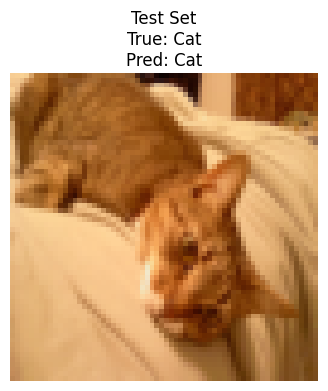

True Label: 1, Predicted Label: 1
Correct: Yes



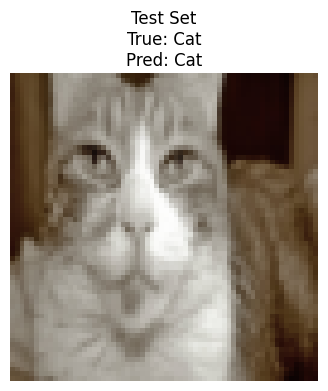

True Label: 1, Predicted Label: 1
Correct: Yes



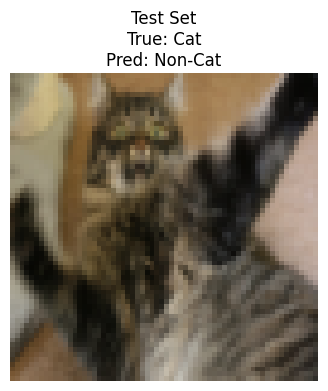

True Label: 1, Predicted Label: 0
Correct: No



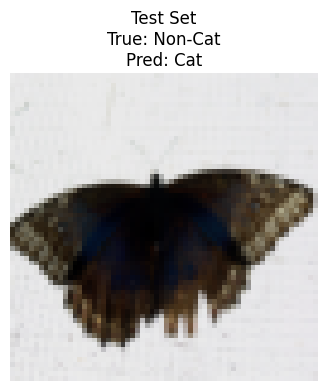

True Label: 0, Predicted Label: 1
Correct: No



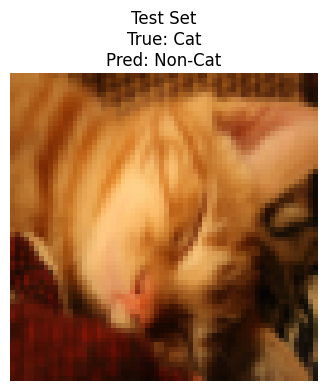

True Label: 1, Predicted Label: 0
Correct: No

Overall Classifier Performance:
Train Accuracy: 1.0000
Test Accuracy: 0.6600

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

     Non-Cat       0.50      0.65      0.56        17
         Cat       0.79      0.67      0.72        33

    accuracy                           0.66        50
   macro avg       0.64      0.66      0.64        50
weighted avg       0.69      0.66      0.67        50



In [12]:
import random

def evaluate_single_image(index, dataset, labels, predictions, set_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(dataset[index].reshape(64, 64, 3))
    plt.axis('off')
    true_label = labels[index]
    pred_label = predictions[index]
    plt.title(f"{set_name} Set\nTrue: {'Cat' if true_label == 1 else 'Non-Cat'}\nPred: {'Cat' if pred_label == 1 else 'Non-Cat'}")
    plt.show()
    print(f"True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Correct: {'Yes' if true_label == pred_label else 'No'}\n")

# Evaluate 5 random images from the test set
print("Evaluating 5 random images from the test set:")
for _ in range(5):
    random_index = random.randint(0, len(test_label) - 1)
    evaluate_single_image(random_index, test_set_x_orig, test_label, test_predictions, "Test")

# Report overall accuracy
train_accuracy = accuracy_score(train_label, train_predictions)
test_accuracy = accuracy_score(test_label, test_predictions)

print("Overall Classifier Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(test_label, test_predictions, target_names=['Non-Cat', 'Cat']))


## MNIST dataset (Optional)- Do exercise 8-10 if you have extra time to practise

In [13]:
#import mnist dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
x_train.shape

(60000, 28, 28)

Label:  8
Image Shape:  (28, 28)


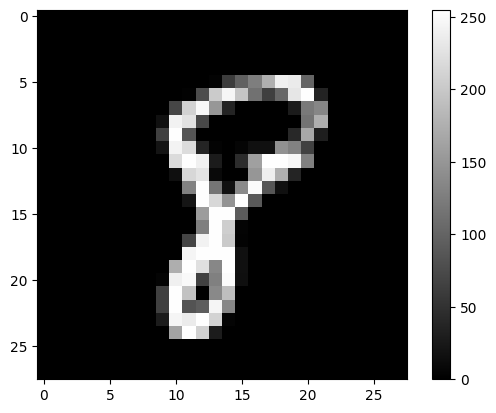

In [21]:
#Note: Run this cell multiple times
index = np.random.randint(0, x_train.shape[0])
print("Label: ", y_train[index])
print("Image Shape: ", x_train[index].shape)
plt.imshow(x_train[index], cmap='gray')
plt.colorbar()

### **Excercise 8:** What is the difference between a black-and-white image and a color image in terms of numerical representation?

### Hint: check the number of channels in the two types of images.

The main difference between a black-and-white image and a color image in terms of numerical representation lies in the number of channels:
Black-and-white (grayscale) images:
Have a single channel
Each pixel is represented by a single value
In the MNIST dataset, we see images with shape (28, 28), indicating a 2D array
Pixel values typically range from 0 (black) to 255 (white)
Color images:
Typically have three channels (RGB - Red, Green, Blue)
Each pixel is represented by three values, one for each color channel
A color image would have a shape like (height, width, 3)
Each channel's values also typically range from 0 to 255

### **Exercise 9:** Select one data sample and flatten it. What is the size of the flattened image and why?

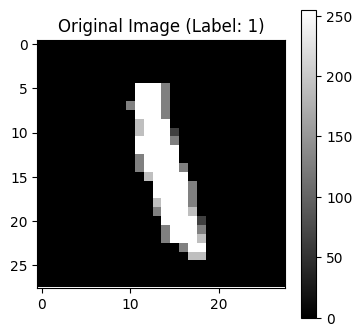

Original image shape: (28, 28)
Flattened image shape: (784,)
Size of the flattened image: 784


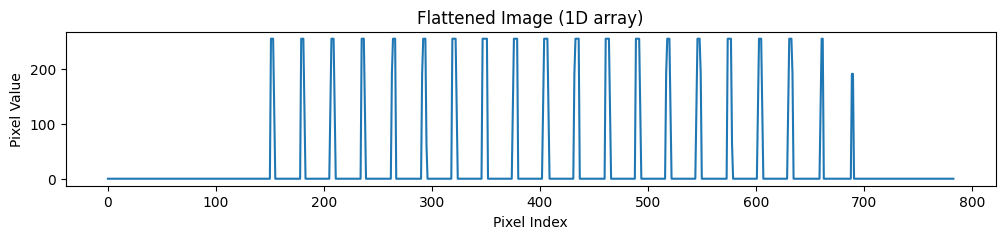

In [22]:
# Select a random image
index = np.random.randint(0, x_train.shape[0])

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(x_train[index], cmap='gray')
plt.title(f"Original Image (Label: {y_train[index]})")
plt.colorbar()
plt.show()

# Flatten the image
flattened_image = x_train[index].flatten()

# Print information about the flattened image
print(f"Original image shape: {x_train[index].shape}")
print(f"Flattened image shape: {flattened_image.shape}")
print(f"Size of the flattened image: {flattened_image.size}")

# Display the flattened image as a 1D array
plt.figure(figsize=(12, 2))
plt.plot(flattened_image)
plt.title("Flattened Image (1D array)")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Value")
plt.show()


### **Excercise 10:** Flatten the Entire Train and Test Datasets and implement a logistic regression model on MNIST dataset. What is the accuracy of your model?

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Flatten the train and test datasets
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("Train set shape:", x_train_flat.shape)
print("Test set shape:", x_test_flat.shape)

# Normalize the data (scale pixel values to 0-1 range)
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

# Create and train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=100)
logistic_model.fit(x_train_flat, y_train)

# Make predictions
train_predictions = logistic_model.predict(x_train_flat)
test_predictions = logistic_model.predict(x_test_flat)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("\nLogistic Regression Results:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_predictions))


Train set shape: (60000, 784)
Test set shape: (10000, 784)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
Train Accuracy: 0.9351
Test Accuracy: 0.9258

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.94      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



**Some food for thought:** What would the architecture of my model be if I used more than one neuron to predict the label?